In [1]:
# Including Dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score,mean_absolute_error,mean_squared_error
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import punctuation
from nltk.corpus import stopwords

In [3]:
# Collection dataset and preprocessing

In [4]:
data = pd.read_csv('emails.csv')

In [5]:
data.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [6]:
data.isnull().sum()

text    0
spam    0
dtype: int64

In [7]:
dataset = data.where(pd.notnull(data))

In [8]:
dataset.shape

(5728, 2)

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [10]:
dataset.head(1)

,text,spam
0,Subject: naturally irresistible your corporate...,1


In [11]:
import re

In [420]:
stop_list = set(stopwords.words('english')) | set(punctuation)

spam_triggers = {"free", "cash", "winner", "click", "offer", "discount", "prize"}
stop_list = stop_list - spam_triggers

print("Final stopword list size:", len(stop_list))


Final stopword list size: 230


In [422]:
l = WordNetLemmatizer()
def preprocess_text(txt):
    txt = str(txt)
    txt = re.sub(r'[^a-zA-Z0-9$%]', ' ', txt)
    words = word_tokenize(txt)
    words = [
        l.lemmatize(word.lower())
        for word in words
        if word.lower() not in stop_list
    ]
    return ' '.join(words)
dataset['text'] = dataset['text'].apply(preprocess_text)


In [423]:
dataset.loc[0]['text']

'subject naturally irresistible corporate identity lt really hard recollect company market full suqgestions information isoverwhelminq good catchy logo stylish statlonery outstanding website make task much easier promise havinq ordered iogo company automaticaily become world ieader isguite ciear without good product effective business organization practicable aim hotat nowadays market promise marketing effort become much effective list clear benefit creativeness hand made original logo specially done reflect distinctive company image convenience logo stationery provided format easy use content management system letsyou change website content even structure promptness see logo draft within three business day affordability marketing break make gap budget satisfaction guaranteed provide unlimited amount change extra fee surethat love result collaboration look portfolio interested'

In [424]:
dataset.head()

,text,spam
0,subject naturally irresistible corporate ident...,1
1,subject stock trading gunslinger fanny merrill...,1
2,subject unbelievable new home made easy im wan...,1
3,subject color printing special request additio...,1
4,subject money get software cd software compati...,1


In [425]:
def remove_url(txt):
    new = " "
    for i in txt:
        if not i.startswith(('http', 'www')):
            new = new + i
    return new        
dataset['text'] = dataset['text'].apply(remove_url)
                    

In [426]:
dataset.head(1)

,text,spam
0,subject naturally irresistible corporate iden...,1


In [427]:
def remove_emoji(txt):
    new = " "
    for i in txt:
        if i.isascii():
            new = new + i
    return new
dataset['text'] = dataset['text'].apply(remove_emoji)
    

In [428]:
dataset.head(1)

,text,spam
0,subject naturally irresistible corporate ide...,1


In [429]:
dataset['spam'].value_counts()

spam
0    4360
1    1368
Name: count, dtype: int64

In [430]:
 # "1" represents spam, while "0" represents not spam.

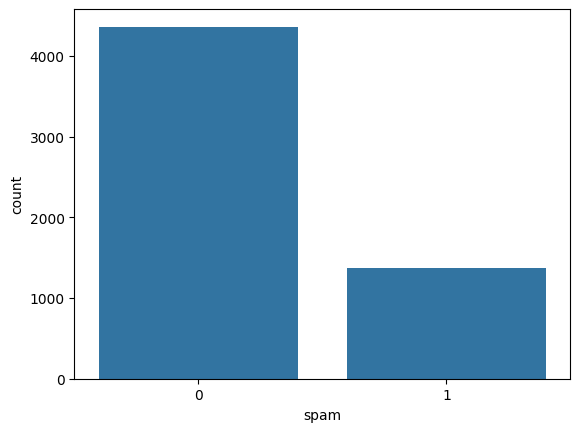

In [431]:
sns.countplot(x='spam',data=dataset)
plt.show()

In [432]:
# Reshampe the unblanced data set to convert into balanced data set using underblanced

In [433]:
from sklearn.utils import resample

In [434]:
spam_data = dataset[dataset['spam'] == 1]

In [435]:
not_spam_data = dataset[dataset['spam'] == 0]

In [436]:
spam_data.shape, not_spam_data.shape

((1368, 2), (4360, 2))

In [437]:
# blacnced data set using underreshampling

In [438]:
df_not_spam_data = resample(not_spam_data,replace=False, n_samples=len(spam_data), random_state=42).reset_index(drop=True)


In [439]:
df_not_spam_data.shape

(1368, 2)

In [440]:
re_dataset = pd.concat([df_not_spam_data, spam_data])

In [441]:
re_dataset.head(10)

,text,spam
0,subject interview schedule jinbaek kim see w...,0
1,subject wednesday meeting eric think skip me...,0
2,subject london research group soon possible ...,0
3,subject congratulation vince thanks note con...,0
4,subject osman sezgen steve kromer requesting...,0
5,subject houston visit soussan thanks message...,0
6,subject impending visit july vince plan hous...,0
7,subject garp convention andreas vincent kami...,0
8,subject rtp project vince targetted conferen...,0
9,subject houston visit soussan seems planned ...,0


In [442]:
re_dataset['spam'].value_counts()

spam
0    1368
1    1368
Name: count, dtype: int64

In [443]:
re_dataset.shape

(2736, 2)

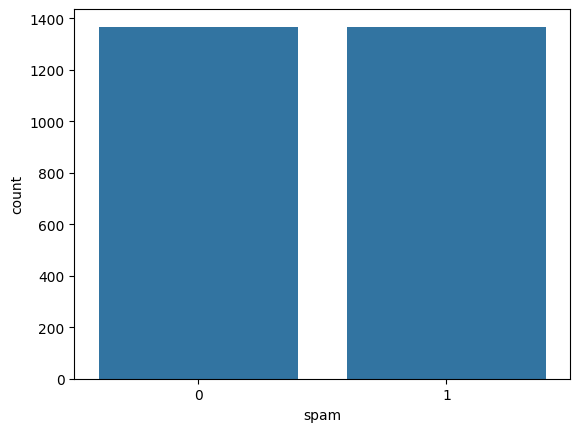

In [444]:
sns.countplot(x='spam',data=re_dataset)
plt.show()

In [445]:
# Divided into Train and  Test data set

In [446]:
x = re_dataset['text']
y = re_dataset['spam']

In [447]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=3)

In [448]:
x_train.shape, x_test.shape,y_test.shape,y_train.shape

((2188,), (548,), (548,), (2188,))

In [449]:
tf = TfidfVectorizer(ngram_range=(1,2), max_features=20000)
tf.fit(x_train)

,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,analyzer,'word'
,stop_words,None
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"


In [450]:
x_train = tf.transform(x_train).toarray()

In [451]:
x_test = tf.transform(x_test).toarray()

In [452]:
# Model Training

In [465]:
lr = LogisticRegression()
lr.fit(x_train,y_train)
lr.score(x_train,y_train)*100, lr.score(x_test,y_test)

(99.49725776965265, 0.9890510948905109)

In [466]:
print(lr.get_params())

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [467]:
print(classification_report(y_test,lr.predict(x_test)))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       267
           1       0.98      1.00      0.99       281

    accuracy                           0.99       548
   macro avg       0.99      0.99      0.99       548
weighted avg       0.99      0.99      0.99       548



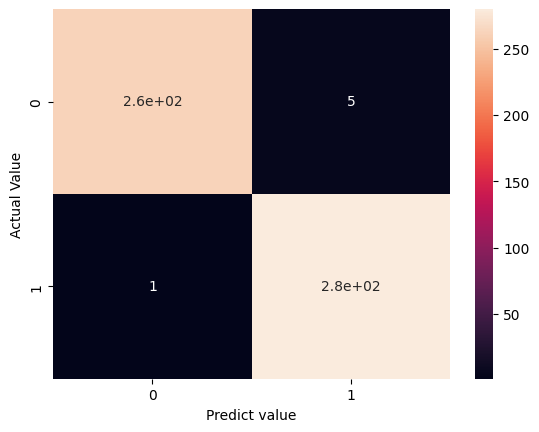

In [468]:
c = confusion_matrix(y_test,lr.predict(x_test))
sns.heatmap(c,annot=True)
plt.xlabel('Predict value')
plt.ylabel('Actual Value')
plt.show()

In [469]:
print(f"mean_absolute_error {mean_absolute_error(y_test,lr.predict(x_test))}")
print(f"mean_suqred_error {mean_squared_error(y_test,lr.predict(x_test))}")

mean_absolute_error 0.010948905109489052
mean_suqred_error 0.010948905109489052


In [470]:
# Test Model using Train data

In [479]:
sam = x_train[1]
sam_ar = np.array(sam)
re_sam = sam_ar.reshape(1,-1)

In [480]:
p = lr.predict(re_sam)
p

array([0])

In [481]:
y_train.values[1]

np.int64(0)

In [482]:
# Load Model and text with test data and random data

In [483]:
from joblib import dump, load

In [484]:
dump(lr,"Spam_prediction_model.ipynb")

['Spam_prediction_model.ipynb']

In [485]:
model_ready = load('Spam_prediction_model.ipynb')

In [486]:
sam_te = x_test[15]
sam_ar_te = np.array(sam_te)
test_sam = sam_ar_te.reshape(1,-1)

In [487]:
y_pre = model_ready.predict(test_sam)
y_pre

array([1])

In [488]:
y_test.values[15]

np.int64(1)

In [489]:
 # "1" represents spam, while "0" represents not spam.

In [490]:
print("This mail is : Spam" if y_pre == 1 else "This mail is: Not Spam")

This mail is : Spam


In [553]:
new_samples = ["Congratulations! You won $1M USD cash prize. Click here!",
               "Hey, are we still meeting tomorrow?"]

new_samples_clean = [preprocess_text(s) for s in new_samples]
new_samples_vec = tf.transform(new_samples_clean)
predictions = model_ready.predict(new_samples_vec)

for text, pred in zip(new_samples, predictions):
    print(f"Text: {text}\nPrediction: {'SPAM' if pred==1 else 'Not Spam'}\n")


Text: Congratulations! You won $1M USD cash prize. Click here!
Prediction: SPAM

Text: Hey, are we still meeting tomorrow?
Prediction: Not Spam

